In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import math

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device:{device}')

using device:cpu



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "F:\flask_test03\Eng2CHN_Transformer\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "F:\flask_test03\Eng2CHN_Transformer\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "F:\flask_test03\Eng2CHN_Transformer\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.sta

In [4]:
file_path = 'data/cmn.txt'
data = []
#读取文件每一行
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:  #读取每一行
        #通过制表符分开
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            english_sentence = parts[0].strip()  #提取英语句子
            chinese_sentence = parts[1].strip()  #提取中文句子
            data.append([english_sentence, chinese_sentence])

#接下来创建DataFrame保存提取的句子
df = pd.DataFrame(data, columns=['English', 'Chinese'])

#将处理后的英文和中文句子保存为两个文件
df['English'].to_csv('data/english_sentences.txt', index=False, header=False)
df['Chinese'].to_csv('data/Chinese_sentences.txt', index=False, header=False)

#显示前几行数据
print(df.head())

  English Chinese
0     Hi.      嗨。
1     Hi.     你好。
2    Run.   你用跑的。
3   Stop!     住手！
4   Wait!     等等！


In [5]:
tokenizer_en = get_tokenizer('basic_english')  #这里是加载分词器
#测试分词器
print('分词器测试：')
tem_sentence = 'I like studying hard.What about you?'
tem_token = tokenizer_en(tem_sentence)
print(tem_token)

分词器测试：
['i', 'like', 'studying', 'hard', '.', 'what', 'about', 'you', '?']


In [6]:
#定义中文分词器
def tokenizer_zh(text):
    return list(text)  #将每个汉字作为一个token


#构建词汇表函数
def build_vocab(sentences, tokenizer):
    '''
    根据给定的句子列表和分词器构建词汇表
    :param sentences: 句子列表
    :param tokenizer: 分词器函数
    :return: 词汇表
    '''

    def yield_tokens(sentences):
        for sentence in sentences:
            yield tokenizer(sentence)

    vocab = build_vocab_from_iterator(yield_tokens(sentences), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    vocab.set_default_index(vocab['<unk>'])  # 设置默认索引为 <unk>
    return vocab



In [7]:
# 从文件中加载句子
with open('data/english_sentences.txt', 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f]

with open('data/chinese_sentences.txt', 'r', encoding='utf-8') as f:
    chinese_sentences = [line.strip() for line in f]

# 构建英文和中文的词汇表
en_vocab = build_vocab(english_sentences, tokenizer_en)
zh_vocab = build_vocab(chinese_sentences, tokenizer_zh)

print(f'英文词汇表大小：{len(en_vocab)}')
print(f'中文词汇表大小：{len(zh_vocab)}')


英文词汇表大小：7193
中文词汇表大小：3657


In [8]:
# 定义将句子转换为索引序列的函数
def process_sentence(sentence, tokenizer, vocab):
    """
    将句子转换为索引序列，并添加 <bos> 和 <eos>,起始符合终结符
    :param sentence: 输入句子
    :param tokenizer: 分词器函数
    :param vocab: 对应的词汇表
    :return: 索引序列
    """
    tokens = tokenizer(sentence)
    tokens = ['<bos>'] + tokens + ['<eos>']
    indices = [vocab[token] for token in tokens]
    return indices


en_sequences = [process_sentence(sentence, tokenizer_en, en_vocab) for sentence in english_sentences]
zh_sequences = [process_sentence(sentence, tokenizer_zh, zh_vocab) for sentence in chinese_sentences]

# 查看示例句子的索引序列
print("示例英文句子索引序列：", en_sequences[0:30])
print("示例中文句子索引序列：", zh_sequences[0:30])

示例英文句子索引序列： [[2, 1475, 4, 3], [2, 1475, 4, 3], [2, 557, 4, 3], [2, 259, 127, 3], [2, 218, 127, 3], [2, 218, 127, 3], [2, 593, 4, 3], [2, 1859, 127, 3], [2, 6, 276, 4, 3], [2, 6, 186, 127, 3], [2, 2078, 68, 127, 3], [2, 4949, 127, 3], [2, 85, 17, 10, 3], [2, 85, 17, 10, 3], [2, 85, 17, 10, 3], [2, 15, 521, 4, 3], [2, 5677, 18, 4, 3], [2, 6, 47, 4, 3], [2, 6, 698, 4, 3], [2, 6, 698, 4, 3], [2, 6, 5, 36, 749, 4, 3], [2, 6, 5, 36, 65, 4, 3], [2, 561, 4, 3], [2, 68, 184, 127, 3], [2, 68, 184, 127, 3], [2, 125, 10, 3], [2, 125, 10, 3], [2, 646, 127, 3], [2, 276, 17, 4, 3], [2, 30, 276, 4, 3]]
示例中文句子索引序列： [[2, 2145, 4, 3], [2, 8, 35, 4, 3], [2, 8, 96, 437, 6, 4, 3], [2, 171, 155, 168, 3], [2, 203, 203, 168, 3], [2, 203, 13, 47, 168, 3], [2, 130, 229, 168, 3], [2, 8, 35, 4, 3], [2, 5, 368, 368, 4, 3], [2, 5, 1074, 7, 4, 3], [2, 10, 48, 205, 4, 3], [2, 1199, 460, 879, 3], [2, 51, 49, 7, 52, 16, 12, 3], [2, 551, 7, 42, 12, 3], [2, 8, 551, 7, 42, 12, 3], [2, 9, 437, 7, 4, 3], [2, 745, 427, 53, 4,

In [9]:
from data_loader import TranslationDataset


def collate_fn(batch):
    '''
    自定义collate_fn，将批次中的样本进行填充对齐
    :param batch:
    :return:
    '''
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    src_batch = pad_sequence(src_batch, padding_value=en_vocab['<pad>'], batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=zh_vocab['<pad>'], batch_first=True)
    return src_batch, trg_batch


#创建数据集对象
dataset = TranslationDataset(en_sequences, zh_sequences)

#划分训练集和验证集
train_data, val_data = train_test_split(dataset, test_size=0.1)

#创建数据加载器
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 8.41470985e-01  5.40302306e-01  5.33168440e-01  8.46009110e-01
   3.10983593e-01  9.50415280e-01  1.76892186e-01  9.84230234e-01
   9.98334166e-02  9.95004165e-01  5.62044992e-02  9.98419278e-01
   3.16175064e-02  9.99500042e-01  1.77818569e-02  9.99841890e-01
   9.99983333e-03  9.99950000e-01  5.62338361e-03  9.99984189e-01
   3.16227239e-03  9.99995000e-01  1.77827847e-03  9.99998419e-01
   9.99999833e-04  9.99999500e-01  5.62341296e-04  9.99999842e-01
   3.1622

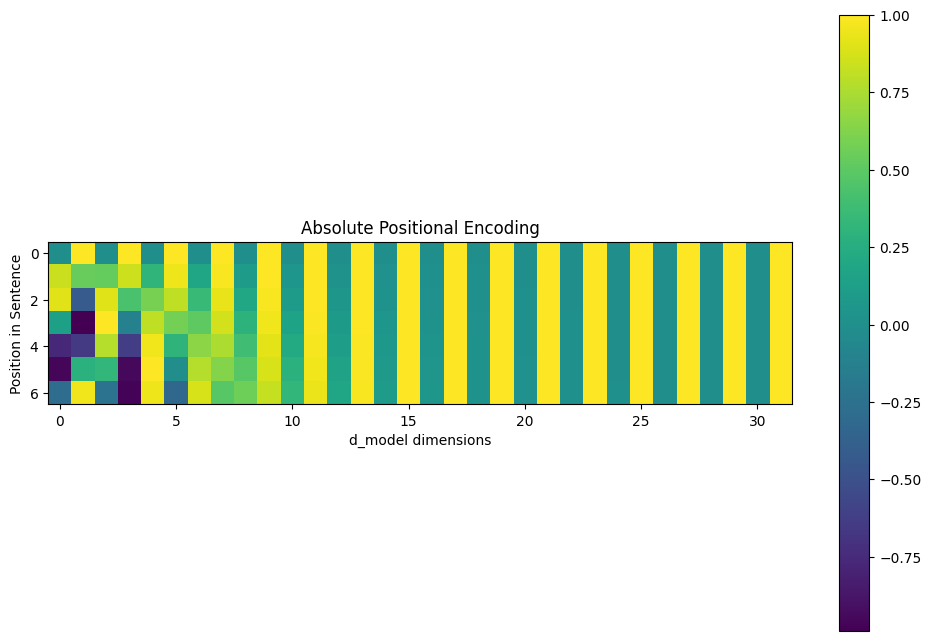

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def get_absolute_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe


# 假设句子长度为8，d_model为32
sentence = "我爱你，中国。"
seq_len = len(sentence)
d_model = 32

absolute_positional_encoding = get_absolute_positional_encoding(seq_len, d_model)
print(absolute_positional_encoding)
# 展示绝对位置编码的效果
plt.figure(figsize=(12, 8))
plt.imshow(absolute_positional_encoding, cmap='viridis')
plt.colorbar()
plt.title("Absolute Positional Encoding")
plt.xlabel("d_model dimensions")
plt.ylabel("Position in Sentence")
plt.show()


In [11]:
from Encoder import Encoder
from Decoder import Decoder


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def make_src_mask(self, src):
        #生成原序列的掩码，屏蔽填充位置
        # 生成源序列的掩码，屏蔽填充位置
        src_mask = (src != en_vocab['<pad>']).unsqueeze(1).unsqueeze(2)
        return src_mask  # [batch_size, 1, 1, src_len]

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != zh_vocab['<pad>']).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]
        trg_len = trg.size(1)
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=trg.device)).bool()
        trg_sub_mask = trg_sub_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, T, T]

        trg_mask = trg_pad_mask & trg_sub_mask  # [B, 1, T, T]

        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)  #给原序列添加掩蔽
        trg_mask = self.make_trg_mask(trg)  #给生成序列添加
        enc_output = self.encoder(src, src_mask)  #经过编码器
        output = self.decoder(trg, enc_output, src_mask, trg_mask)
        return output
        
        
        
        

In [12]:
input_dim = len(en_vocab)
output_dim = len(zh_vocab)
print(input_dim)
print(output_dim)
d_model = 512  #词向量维度
num_heads = 8  #多头注意力机制的头数
d_ff = 2048  #这里是FNN的隐藏层维度
num_layers = 3
dropout = 0.1

#实例化编码器，解码器和Transformer
encoder = Encoder(input_dim, d_model, num_heads, d_ff, num_layers, dropout)
decoder = Decoder(output_dim, d_model, num_heads, d_ff, num_layers, dropout)
model = Transformer(encoder, decoder).to(device)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=zh_vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

7193
3657


In [13]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg[:, :-1])  # 输入不包括最后一个词
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)  # 目标不包括第一个词
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


# 定义验证函数
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)
            output = model(src, trg[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [14]:
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss = evaluate(model, val_dataloader, criterion)
    print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

KeyboardInterrupt: 

In [ ]:
#定义翻译函数
def translate_sentence(sentence, model, en_vocab, zh_vocab, tokenizer_en, max_len=50):
    """
    翻译英文句子为中文
    :param sentence: 英文句子（字符串）
    :param model: 训练好的 Transformer 模型
    :param en_vocab: 英文词汇表
    :param zh_vocab: 中文词汇表
    :param tokenizer_en: 英文分词器
    :param max_len: 最大翻译长度
    :return: 中文翻译（字符串）
    """
    model.eval()
    tokens = tokenizer_en(sentence)
    tokens = ['<bos>'] + tokens + ['<eos>']
    src_indices = [en_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)  # [1, src_len]
    src_mask = model.make_src_mask(src_tensor)
    with torch.no_grad():
        enc_output = model.encoder(src_tensor, src_mask)
    trg_indices = [zh_vocab['<bos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)  # [1, trg_len]
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_output, src_mask, trg_mask)
        pred_token = output.argmax(-1)[:, -1].item()
        trg_indices.append(pred_token)
        if pred_token == zh_vocab['<eos>']:
            break
    trg_tokens = [zh_vocab.lookup_token(idx) for idx in trg_indices]
    return ''.join(trg_tokens[1:-1])  # 去除 <bos> 和 <eos>



input_sentence = 'How old are you?'
translation = translate_sentence(input_sentence, model, en_vocab, zh_vocab, tokenizer_en)
print(f"英文句子: {input_sentence}")
print(f"中文翻译: {translation}")

# 您可以在此处输入其他英文句子进行测试
while True:
    input_sentence = input("请输入英文句子（输入 'quit' 退出）：")
    if input_sentence.lower() == 'quit':
        break
    translation = translate_sentence(input_sentence, model, en_vocab, zh_vocab, tokenizer_en)
    print(f"中文翻译: {translation}")